In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class GDN(nn.Module):
    def __init__(self,
                 n_channels,
                 gamma_init=.1,
                 reparam_offset=2**-18,
                 beta_min=1e-6,
                 apply_independently=False):
        super(GDN, self).__init__()
        self.n_channels = n_channels
        self.gamma_init = gamma_init
        self.reparam_offset = reparam_offset
        self.beta_min = beta_min
        self.beta_reparam = (self.beta_min + self.reparam_offset**2)**0.5
        self.apply_independently = apply_independently
        if apply_independently:
            self.groups = n_channels
        else:
            self.groups = 1
        self.initialise_params()

    def initialise_params(self):
        gamma_bound = self.reparam_offset
        gamma = torch.eye(self.n_channels, dtype=torch.float)
        gamma = gamma.view(self.n_channels, self.n_channels, 1, 1)
        gamma = torch.sqrt(self.gamma_init*gamma + self.reparam_offset**2)
        gamma = torch.mul(gamma, gamma)
        if self.apply_independently:
            gamma = gamma[:, 0, :, :].unsqueeze(1)
        self.gamma = nn.Parameter(gamma)
        beta = torch.ones((self.n_channels,))
        beta = torch.sqrt(beta + self.reparam_offset**2)
        self.beta = nn.Parameter(beta)

    def forward(self, x):
        """Forward pass of the layer
        Input must be shape: [batch_size, channels, height, width]
        """
        self.inputs = x
        self.gamma.data = torch.clamp(self.gamma.data, min=self.reparam_offset)
        self.beta.data = torch.clamp(self.beta.data, min=self.beta_reparam)
        norm_pool = F.conv2d(torch.mul(x, x), self.gamma, bias=self.beta,
                             groups=self.groups)
        norm_pool = torch.sqrt(norm_pool)
        
        output = x / norm_pool
        return output

In [35]:
gdn = GDN(n_channels=1)

In [36]:
type(gdn.gamma), type(gdn.gamma.data)

(torch.nn.parameter.Parameter, torch.Tensor)

In [51]:
np.random.seed(42)
sample_input = np.random.uniform(size=(1,1,28,28))
sample_input_pth = torch.FloatTensor(sample_input)

In [60]:
a = gdn(sample_input_pth).detach()
a.shape

torch.Size([1, 1, 28, 28])

In [61]:
np.allclose(sample_input_pth.numpy(), sample_input)

True

In [62]:
gdn.gamma.shape, gdn.beta.shape

(torch.Size([1, 1, 1, 1]), torch.Size([1]))

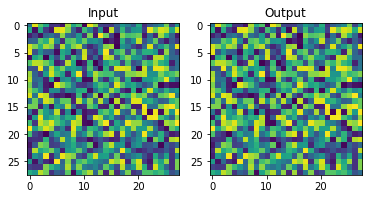

In [63]:
plt.figure()
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(sample_input_pth.numpy().squeeze())
plt.subplot(1,2,2)
plt.imshow(a.numpy().squeeze())
plt.title("Output")
plt.show()

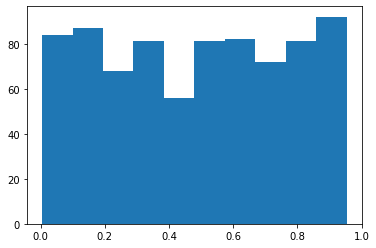

In [64]:
plt.figure()
plt.hist(a.numpy().squeeze().ravel())
plt.show()

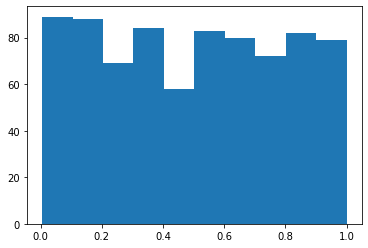

In [65]:
plt.figure()
plt.hist(sample_input_pth.numpy().squeeze().ravel())
plt.show()

In [66]:
t1 = torch.FloatTensor([1,2,3])
t2 = torch.FloatTensor([4,5,6])

t1, t2

(tensor([1., 2., 3.]), tensor([4., 5., 6.]))

In [67]:
torch.mul(t1, t2)

tensor([ 4., 10., 18.])